In [1]:
import os, fitsio, glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table,join,vstack

In [2]:
# Define paths where files are
tiles=['80605','80607','80609']

vifiles={'80605':'/global/cfs/cdirs/desi/sv/vi/TruthTables/Blanc/QSO/desi-vi_QSO_tile80605_nightdeep_merged_all_210223.csv',
         '80607':'/global/cfs/cdirs/desi/sv/vi/TruthTables/Blanc/QSO/desi-vi_QSO_tile80607_nightdeep_merged_all_210214.csv',
         '80609':'/global/cfs/cdirs/desi/sv/vi/TruthTables/Blanc/QSO/desi-vi_QSO_tile80609_nightdeep_merged_all_210210.csv'}
squeze_model = 'boss'
sqfiles_path='/global/cfs/cdirs/desi/users/hiramk/desi/squeze_tests/cascades/4x_depth' 
rrfiles_path='/global/cfs/cdirs/desi/users/rongpu/redux/cascades/4x_depth'

In [25]:
# Function to merge all spectrographs files into a single file
def merge_data(files,columns=None):
    merged_data=[]
    for file in files:
        merged_data.append(Table(fitsio.read(file,columns=columns)))
    return vstack(merged_data)

def load_VI(file):
    # Loading whole VI table and dropping columns we won't need
    vidata=Table.read(file)
    vidata.remove_columns(['all_VI_issues','Redrock_z','Redrock_spectype','all_VI_comments','merger_comment','N_VI'])
    vidata.rename_column('best_z', 'VI_Z')
    vidata.rename_column('best_spectype', 'VI_TYPE')
    vidata.rename_column('best_quality', 'VI_QUALITY')
    return vidata

def plot_redshifts(data,tile,min_qual=2.5,min_prob=0.,min_z=0.,max_z=10):
    w_qual=data['VI_QUALITY']>=min_qual
    w_VI=(data['VI_TYPE']=='QSO') & (data['VI_Z'] > min_z) & (data['VI_Z'] < max_z)
    w_RR=data['RR_TYPE']=='QSO'
    SQ_QSO=(data['SQ_TYPE']==3)|(data['SQ_TYPE']==30)|(data['SQ_TYPE']==35)|(data['SQ_TYPE']==305)
    w_SQ=SQ_QSO&(data['PROB']>min_prob)
    
    w_data=data[w_qual & w_VI & w_RR & w_SQ]
    fig,ax=plt.subplots(1,2,figsize=(8,4))
    fig.suptitle(f'TILE {tile}')
    ax[0].plot(w_data['VI_Z'],w_data['RR_Z'],'.')
    ax[0].set_xlabel('Z (VI)')
    ax[0].set_ylabel('Z (RR)')
    ax[1].plot(w_data['VI_Z'],w_data['SQ_Z'],'.')
    ax[1].set_xlabel('Z (VI)')
    ax[1].set_ylabel('Z (SQ)')
    fig.show()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

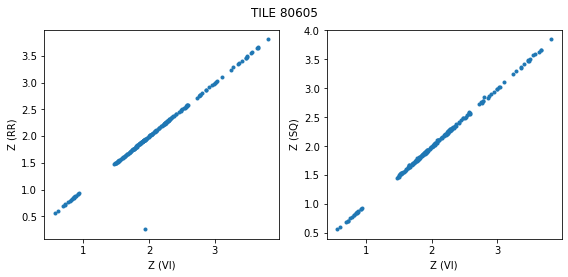

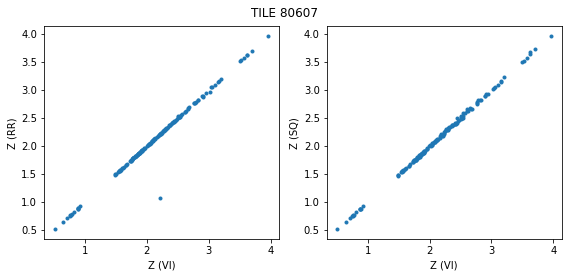

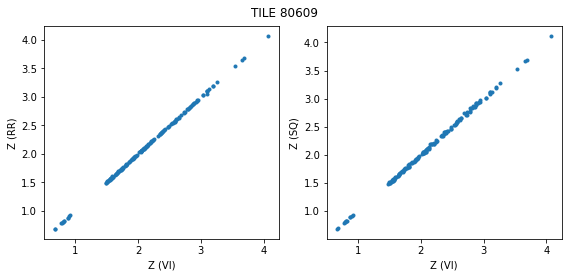

In [28]:
for tile in tiles:
    # Load VI table
    vi_table=load_VI(vifiles[tile])
    rrfiles=sorted(glob.glob(os.path.join(rrfiles_path,tile,'zbest*subset-1.fits')))
    # Load RedRock table and rename columns
    rr_table=merge_data(rrfiles,columns=['TARGETID','Z','SPECTYPE','ZWARN'])
    rr_table.rename_column('Z','RR_Z')
    rr_table.rename_column('SPECTYPE','RR_TYPE')
    # Load SQUEzE table
    sqfiles=sorted(glob.glob(os.path.join(sqfiles_path,tile,f'{squeze_model}*.fits')))
    sq_table=merge_data(sqfiles,columns=['TARGETID','PROB','Z_TRY','CLASS_PREDICTED'])
    sq_table.rename_column('Z_TRY','SQ_Z')
    sq_table.rename_column('CLASS_PREDICTED','SQ_TYPE')
    
    
    # Merge data into single table
    data = join(vi_table,rr_table,keys='TARGETID')
    data = join(data,sq_table,keys='TARGETID')
    plot_redshifts(data,tile,min_prob=0.9)